# Import and Read

We begin with importing the necessary libraries and reading in the data:

In [56]:
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline


# Obviously, reading the data is a good start
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Exploratory Analysis

Now that some basic house-cleaning has been taken care of, let's break for a bit of exploratory data analysis, featuring some super-cool visualizations!

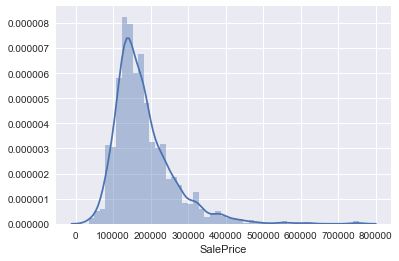

In [27]:
sns.set_style("darkgrid")
sns.distplot(train['SalePrice'])

Turns out that houses in Ames are pretty cheap! Many below 200k and nearly all of them less than 300k! We'll now get the correlations of the numeric values and plot a heatmap of that data.

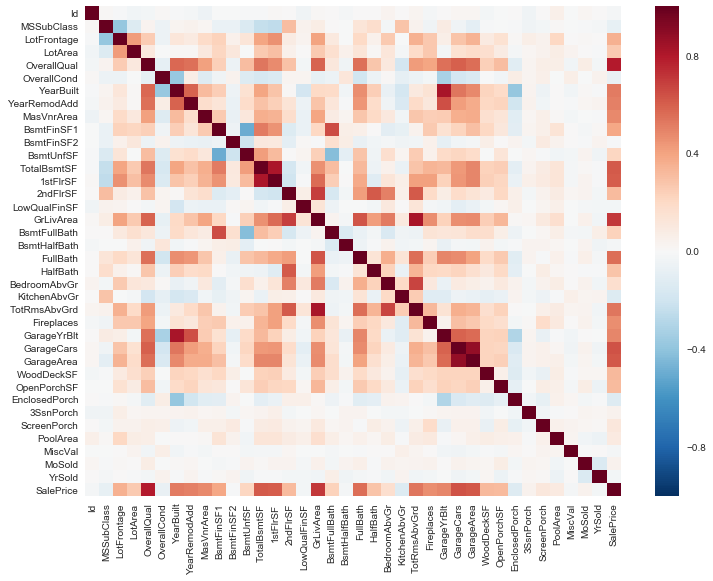

In [28]:
corr_frame = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_frame)

Looking at the heatmap above, it is apparent that we still have an awful lot of features to pick through, and we're just talking numerical variables here. Let's try cutting out the low variance variables and see what happens:

Next, we'll add a function to aid in imputing missing values. Besides the dataframe, this function takes sequences (in this case, tuples) of categorical features and numeric features that require special handling.

Additionally, we're going to substitute categorical variables with dummy variables, so that we can get correlations and easily fit regression lines.

In [39]:
def fill_values(data, s_cats, s_nums):
    """
    Fill all the columns with the median or mode of the column, depending on type.
    
    :param data: The data frame containing the aforementioned columns.
    :param s_cats: Categorical columns requiring special handling
    :param s_nums: Numeric columns requiring special handling
    :return: The same data frame with the values filled in with medians and modes.
    """
    numeric_types = (np.dtype('int64'), np.dtype('float64'))

    for col in data.columns.values:
        if col in special_cats:
            data[col] = data[col].fillna('NoExist')
        elif col in special_nums:
            data[col] = data[col].fillna(0)
        elif data[col].dtype in numeric_types:
            data[col] = data[col].fillna(int(data[col].median()))
        elif data[col].dtype is np.dtype('object'):
            data[col] = data[col].fillna(data[col].mode().iloc[0])

    return data


def dummy_vars(data):
    """
    Replace categorical variables with dummy variables.

    :param data: The data frame containing the aforementioned columns.
    :return: Transformed data frame with dummy variables.
    """
    cat_cols = [col for col in data.columns.values 
                if data[col].dtype is np.dtype('object')]
    prefixes = [name.lower() for name in cat_cols]
    return pd.get_dummies(data, columns=cat_cols, prefix=prefixes)


# Impute special values
special_cats = ('FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                'GarageCond', 'PoolQC', 'Fence', 'MiscFeature')
special_nums = ('GarageYrBlt')

# partial_clean_train = fill_values(train, special_cats, special_nums)
clean_train = (train.pipe(fill_values, s_cats=special_cats, s_nums=special_nums)
               .pipe(dummy_vars))
clean_test = (test.pipe(fill_values, s_cats=special_cats, s_nums=special_nums)
              .pipe(dummy_vars))
# dummy_train = dummy_vars(train)
# dummy_test = dummy_vars(test)

It is unsurprising that certain features are highly correlated with each other. For example, garage area and number of cars that can go in a garage. The latter is strongly dependent on the former. Cases where we have these highly-corrlated variables are where we can probably cut one or the other.

Below, let's use a series of strip plots to try to get some idea of what categorical variables might be particularly predictive:

In [32]:
for num, col in enumerate(partial_clean_train.columns):
    if partial_clean_train[col].dtype is np.dtype('object'):
        plt.figure(num)
        sns.stripplot(x=col, y='SalePrice', data=partial_clean_train, jitter=True)

NameError: name 'partial_clean_train' is not defined

In [51]:
thresh = VarianceThreshold(threshold=(.8 * (1 - .8)))
data_no_lv = pd.DataFrame(thresh.fit_transform(clean_train))
col_labels = [clean_train.columns[x] for x in thresh.get_support(indices=True)]
data_no_lv.columns = col_labels
data_no_lv.drop('Id', axis='columns', inplace=True)

Cool. So, that eliminated a few features. Different thresholds may yet yield different results, but for now, let's select a few features from this remaining set of features, using a univariate testing method:

In [70]:
X = data_no_lv.drop('SalePrice', axis='columns')
Y = data_no_lv.loc[:, 'SalePrice']

# Try SelectKBest with a different test to see if that aids feature selection at all?
ratings = SelectKBest(mutual_info_regression, k=50)
fit_data = ratings.fit_transform(X, Y)
col_labels = [X.columns[x] for x in ratings.get_support(indices=True)]
data_final = pd.DataFrame(fit_data)
data_final.columns = col_labels

# Model Time!
So, the features that have been selected are...interesting. These are not necessarily the ones that I would have selected, but there we go. Maybe different selection methods will do, but we'll see what we can get with the features currently selected and a random forest model. This data has not been transformed much beyond the cleaning seen above. Further cleaning and massaging is likely to make this better.

In [71]:
regress_model = RandomForestRegressor(n_estimators=100)
regress_model.fit(data_final, Y)
score = regress_model.score(data_final, Y)
score

0.98315917011039522

Just on this first run of the model, we can already see that R<sup>2</sup> is pretty high. 96% of the variance is explained by this first run of the model!? Not too bad!

Let's now give a shot at getting some predictions and writing them to a CSV for submission to Kaggle:

In [72]:
predictions = pd.DataFrame(regress_model.predict(clean_test[col_labels]), 
                           columns=['SalePrice'])
final_preds = pd.concat([test.loc[:, 'Id'], predictions], axis='columns')

with open('submission.csv', 'w') as csvf:
    w = csv.writer(csvf)
    
    # Write the header
    w.writerow(['Id', 'SalePrice'])
    
    # Write the rows
    for pred in final_preds.iterrows():
        w.writerow([int(pred[1]['Id']), pred[1]['SalePrice']])